In [1]:
import matplotlib.pyplot as plt
import json
import itertools
import pandas as pd

In [2]:
with open('results.json') as f:
    data = json.load(f)
    
data_list = []

for run_idx, run in enumerate(data):
    for planner_run in run['planner_runs']:
        for ptp_idx, ptp_run in enumerate(planner_run['segments']):
            data_list.append({
                'run_idx': run_idx,
                'ptp_idx': ptp_idx,
                'apples': run['number_of_apples'],
                **planner_run,
                **ptp_run
            })
        
data_df = pd.DataFrame(data_list)

data_df.head()

,run_idx,ptp_idx,apples,intermediate_planner,ordering,segments,apple,feasible_solve_milliseconds,path_length,prm_edges_after_solve,prm_nodes_after_solve,solved
0,0,0,42,PRM,random,"[{'apple': [-2.2903766585300316, 1.79430988658...","[-2.2903766585300316, 1.794309886584009, 5.157...",8,183.286093,24,8,True
1,0,1,42,PRM,random,"[{'apple': [-2.2903766585300316, 1.79430988658...","[2.346319599736985, -4.161062408750059, 0.6138...",8,227.116055,112,17,True
2,0,2,42,PRM,random,"[{'apple': [-2.2903766585300316, 1.79430988658...","[-2.616665180714363, -0.4755651194033054, 6.31...",15,192.565020,506,47,True
3,0,3,42,PRM,random,"[{'apple': [-2.2903766585300316, 1.79430988658...","[-2.2246790054291012, 0.7747436293501531, 4.63...",41,75.574050,2794,175,True
4,0,4,42,PRM,random,"[{'apple': [-2.2903766585300316, 1.79430988658...","[-1.8932079926002243, 1.021596304547263, 3.384...",21,83.490532,3884,231,True


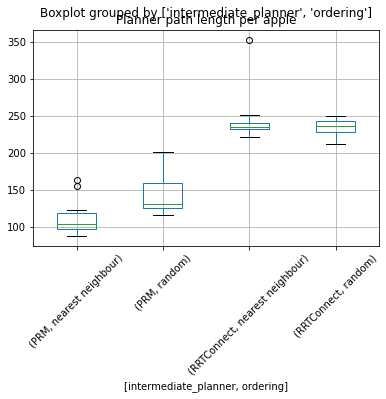

In [72]:
per_run_mean = data_df[(data_df.solved) & (data_df.ptp_idx != 0)]\
    .groupby(['intermediate_planner', 'ordering', 'run_idx'])\
    .path_length\
    .mean()\
    .to_frame()\
    .boxplot(by=['intermediate_planner','ordering'], rot=45)

plt.title('Planner path length per apple')
plt.show()

(0.9, 1.0)

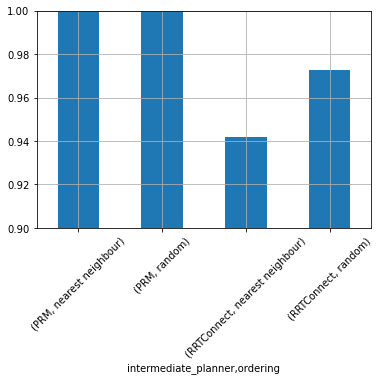

In [73]:
# TODO: Shoujld I be taking the mean on a per-run basis? This current method is biased to runs with many apples.
data_df[(data_df.ptp_idx != 0)]\
    .groupby(['intermediate_planner', 'ordering'])\
    .solved.mean()\
    .plot(kind='bar',rot=45,grid=True)

plt.ylim(0.9,1)

In [77]:
data_df[(data_df.ptp_idx != 0)].groupby('apples').path_length.mean()

apples
8     226.161720
10    196.636219
42    182.851254
49    185.160580
51    179.625709
52    171.506924
64    179.260920
72    170.449932
83    168.424437
95    172.714355
Name: path_length, dtype: float64